In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.0.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
dataset_path = './zh_dataset'

train_file = os.path.join(dataset_path, 'cnews.train.seg.txt')
val_file = os.path.join(dataset_path, 'cnews.val.seg.txt')
test_file = os.path.join(dataset_path, 'cnews.test.seg.txt')
vocab_file = os.path.join(dataset_path, 'cnews.vocab.txt')
category_file = os.path.join(dataset_path, 'cnews.category.txt')

In [3]:
class Vocab:
    def __init__(self, filename, num_word_threshold):
        self._word_to_id = {}
        self._unk = -1
        self._num_word_threshold = num_word_threshold
        self._read_dict(filename)
    
    def _read_dict(self, filename):
        with open(filename, 'r') as f:
            lines = f.readlines()
        for line in lines:
            word, frequency = line.strip('\r\n').split('\t')
            frequency = int(frequency)
            if frequency < self._num_word_threshold:
                continue
            idx = len(self._word_to_id)
            if word == '<UNK>':
                self._unk = idx
            self._word_to_id[word] = idx
    
    def word_to_id(self, word):
        return self._word_to_id.get(word, self._unk)
    
    @property
    def unk(self):
        return self._unk
    
    def size(self):
        return len(self._word_to_id)
    
    def sentence_to_id(self, sentence):
        word_ids = [self.word_to_id(cur_word) \
                    for cur_word in sentence.split()]
        return word_ids


class CategoryDict:
    def __init__(self, filename):
        self._category_to_id = {}
        with open(filename, 'r') as f:
            lines = f.readlines()
        for line in lines:
            category = line.strip('\r\n')
            idx = len(self._category_to_id)
            self._category_to_id[category] = idx
    
    def size(self):
        return len(self._category_to_id)
        
    def category_to_id(self, category):
        if not category in self._category_to_id:
            raise Execption(
                "%s is not in our category list" % category_name)
        return self._category_to_id[category]
        
vocab = Vocab(vocab_file, 10)
vocab_size = vocab.size()
print('vocab_size: %d' % vocab_size)

category_vocab = CategoryDict(category_file)
num_classes = category_vocab.size()
print('num_classes: %d' % num_classes)
test_str = '时尚'
print('label: %s, id: %d' % (test_str, category_vocab.category_to_id(test_str)))

vocab_size: 77323
num_classes: 10
label: 时尚, id: 5


In [4]:
max_length = 500

def parse_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    x = []
    y = []
    
    for line in lines:
        label, content = line.strip('\n').split('\t')
        id_label = category_vocab.category_to_id(label)
        id_words = vocab.sentence_to_id(content)
        if len(id_words) > max_length:
            id_words = id_words[0:max_length]
        else:
            pad = [vocab.unk for _ in range(max_length - len(id_words))]
            id_words = id_words + pad
        x.append(id_words)
        y.append(id_label)
    return tf.data.Dataset.from_tensor_slices((x, y))

train_dataset = parse_data(train_file)
val_dataset = parse_data(val_file)
test_dataset = parse_data(test_file)

In [5]:
buffer_size = 50000
batch_size = 64

train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size).batch(batch_size)

In [6]:
for x, y in train_dataset.take(5):
    print(x, y)
    
for x, y in val_dataset.take(5):
    print(x, y)

tf.Tensor(
[[ 3759    11    25 ...     7    13    83]
 [ 2990   303  3366 ...     0     0     0]
 [13792    11   187 ...     0     0     0]
 ...
 [  467    11    91 ...     0     0     0]
 [   15  2296    14 ...   376  3005 22072]
 [  788     8 16974 ...     0     0     0]], shape=(64, 500), dtype=int32) tf.Tensor(
[4 3 6 2 4 3 7 0 3 5 5 5 7 9 2 8 7 4 6 5 4 4 1 4 1 1 5 5 3 2 0 7 0 3 2 1 0
 1 8 2 2 4 5 8 6 3 9 0 7 7 7 4 3 5 7 8 8 5 1 0 1 5 1 4], shape=(64,), dtype=int32)
tf.Tensor(
[[  706  2014   117 ...     0     0     0]
 [    0   149 15519 ...    40     1   163]
 [ 6117    11   726 ...     0     0     0]
 ...
 [   71   612   144 ...    70     2  1193]
 [ 2378     2 18935 ...     0     0     0]
 [11498     4  4416 ...  1155     1  3920]], shape=(64, 500), dtype=int32) tf.Tensor(
[9 8 1 9 5 9 7 1 9 8 8 4 1 9 5 4 0 6 9 3 3 6 8 5 1 6 5 4 9 4 3 5 6 3 4 6 1
 4 1 3 3 0 8 4 9 8 6 7 1 5 6 5 2 5 4 7 2 1 8 4 4 3 2 6], shape=(64,), dtype=int32)
tf.Tensor(
[[    0 14828  1130 ... 28784     1 156

In [7]:
embedding_dim = 16

bi_rnn_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units = 32, return_sequences = False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(10, activation='softmax'),
])

bi_rnn_model.summary()
bi_rnn_model.compile(optimizer = 'adam',
                     loss = 'sparse_categorical_crossentropy',
                     metrics = ['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           1237168   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 1,252,122
Trainable params: 1,252,122
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = bi_rnn_model.fit(
    train_dataset,
    epochs = 30,
    validation_data = val_dataset)


Epoch 1/30
782/782 [==============================] - 59s 76ms/step - loss: 0.8642 - accuracy: 0.7247 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
782/782 [==============================] - 37s 47ms/step - loss: 0.1924 - accuracy: 0.9464 - val_loss: 0.4457 - val_accuracy: 0.8862
Epoch 3/30
782/782 [==============================] - 36s 47ms/step - loss: 0.0596 - accuracy: 0.9851 - val_loss: 0.4729 - val_accuracy: 0.8852
Epoch 4/30
782/782 [==============================] - 37s 47ms/step - loss: 0.0278 - accuracy: 0.9935 - val_loss: 0.5707 - val_accuracy: 0.8774
Epoch 5/30
782/782 [==============================] - 36s 47ms/step - loss: 0.0170 - accuracy: 0.9959 - val_loss: 0.5390 - val_accuracy: 0.8948
Epoch 6/30
782/782 [==============================] - 37s 47ms/step - loss: 0.0082 - accuracy: 0.9979 - val_loss: 0.7007 - val_accuracy: 0.8688
Epoch 7/30
782/782 [==============================] - 36s 47ms/step - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.6289 - val_a

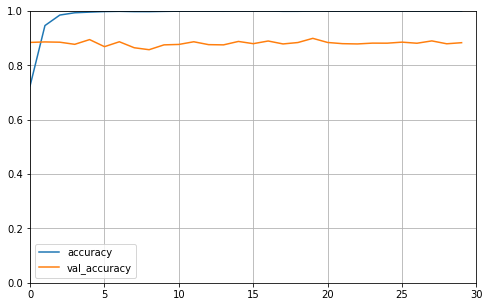

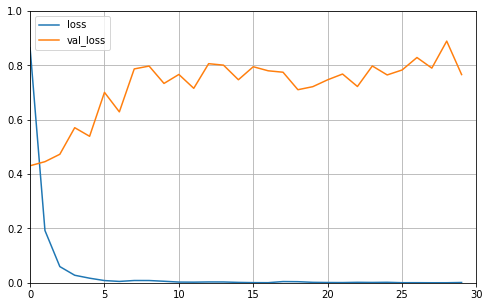

In [9]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', 30, 0, 1)
plot_learning_curves(history, 'loss', 30, 0, 1)

In [10]:
bi_rnn_model.evaluate(test_dataset)

157/157 [==============================] - 3s 17ms/step - loss: 0.5705 - accuracy: 0.9123


[0.5704858062943076, 0.9123]